In [35]:
import pandas as pd
import nltk
from pyarabic.araby import strip_tashkeel, strip_harakat, strip_lastharaka, strip_tatweel, normalize_hamza
import re

def delete_links(input_text):
    pettern  = r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))'''
    out_text = re.sub(pettern, ' ', input_text)
    return out_text

def delete_repeated_characters(input_text):
    pattern  = r'(.)\1{2,}'
    out_text = re.sub(pattern, r"\1\1", input_text)
    return out_text

def replace_letters(input_text):
    replace = {"أ": "ا","ة": "ه","إ": "ا","آ": "ا","": ""}
    replace = dict((re.escape(k), v) for k, v in replace.items())
    pattern = re.compile("|".join(replace.keys()))
    out_text = pattern.sub(lambda m: replace[re.escape(m.group(0))], input_text)
    return out_text

def clean_text(input_text):
    replace = r'[/(){}\[\]|@âÂ,;\?\'\"\*…؟–’،!&\+-:؛-]'
    out_text = re.sub(replace, " ", input_text)
    words = nltk.word_tokenize(out_text)
    out_text = ' '.join(words)
    return out_text

def remove_vowelization(input_text):
    vowelization = re.compile(""" ّ|َ|ً|ُ|ٌ|ِ|ٍ|ْ|ـ""", re.VERBOSE)
    out_text = re.sub(vowelization, '', input_text)
    return out_text

def delete_stopwords(input_text):
    stop_words = set(nltk.corpus.stopwords.words("arabic") + nltk.corpus.stopwords.words("english"))
    tokenizer = nltk.tokenize.WhitespaceTokenizer()
    tokens = tokenizer.tokenize(input_text)
    out_text = [w for w in tokens if not w in stop_words]
    out_text = ' '.join(out_text)
    return out_text


# improved the rouge L
def preprocess_text(text):
    text = delete_links(text)
    text = delete_repeated_characters(text)
    text = strip_tashkeel(text)
    text = strip_tatweel(text)
    text= clean_text(text) 
    text = remove_vowelization(text)
    text = replace_letters(text)
    text = delete_stopwords(text)
    return text


In [36]:
import glob
import pandas as pd


file_pattern = f"stories*.csv"
csv_files = glob.glob(file_pattern)

dataframes = []
for file in csv_files:
    df = pd.read_csv(file )
    dataframes.append(df)

for df in dataframes:
    df.story = df.story.apply(preprocess_text)

In [60]:
def calculate_word_count(df):
    return df['story'].apply(lambda x: len(x.split()))

# Create a new DataFrame to store word count for each DataFrame
word_count_df = pd.DataFrame()

# Iterate through each DataFrame in the list
for idx, df in enumerate(dataframes, 1):
    # Calculate word count for each row in the current DataFrame
    word_count_col = f'df{idx}_word_count'
    word_count_df[word_count_col] = calculate_word_count(df)

# Output the final DataFrame with word count for each DataFrame
word_count_df

,df1_word_count,df2_word_count,df3_word_count,df4_word_count,df5_word_count,df6_word_count,df7_word_count,df8_word_count,df9_word_count,df10_word_count,df11_word_count
0,512,257,168,258,532,295,275,239,89,281,72
1,310,160,134,1269,637,322,321,70,260,153,211
2,422,40,101,265,527,358,376,225,315,45,179
3,674,312,110,273,692,326,144,135,288,238,84
4,159,475,91,269,684,375,415,466,133,115,244
...,...,...,...,...,...,...,...,...,...,...,...
995,202,191,107,46,579,364,166,152,152,136,1003
996,385,134,158,628,784,339,807,181,240,76,197
997,211,288,89,418,686,99,286,158,190,203,279
998,244,210,80,435,483,492,90,117,90,99,484


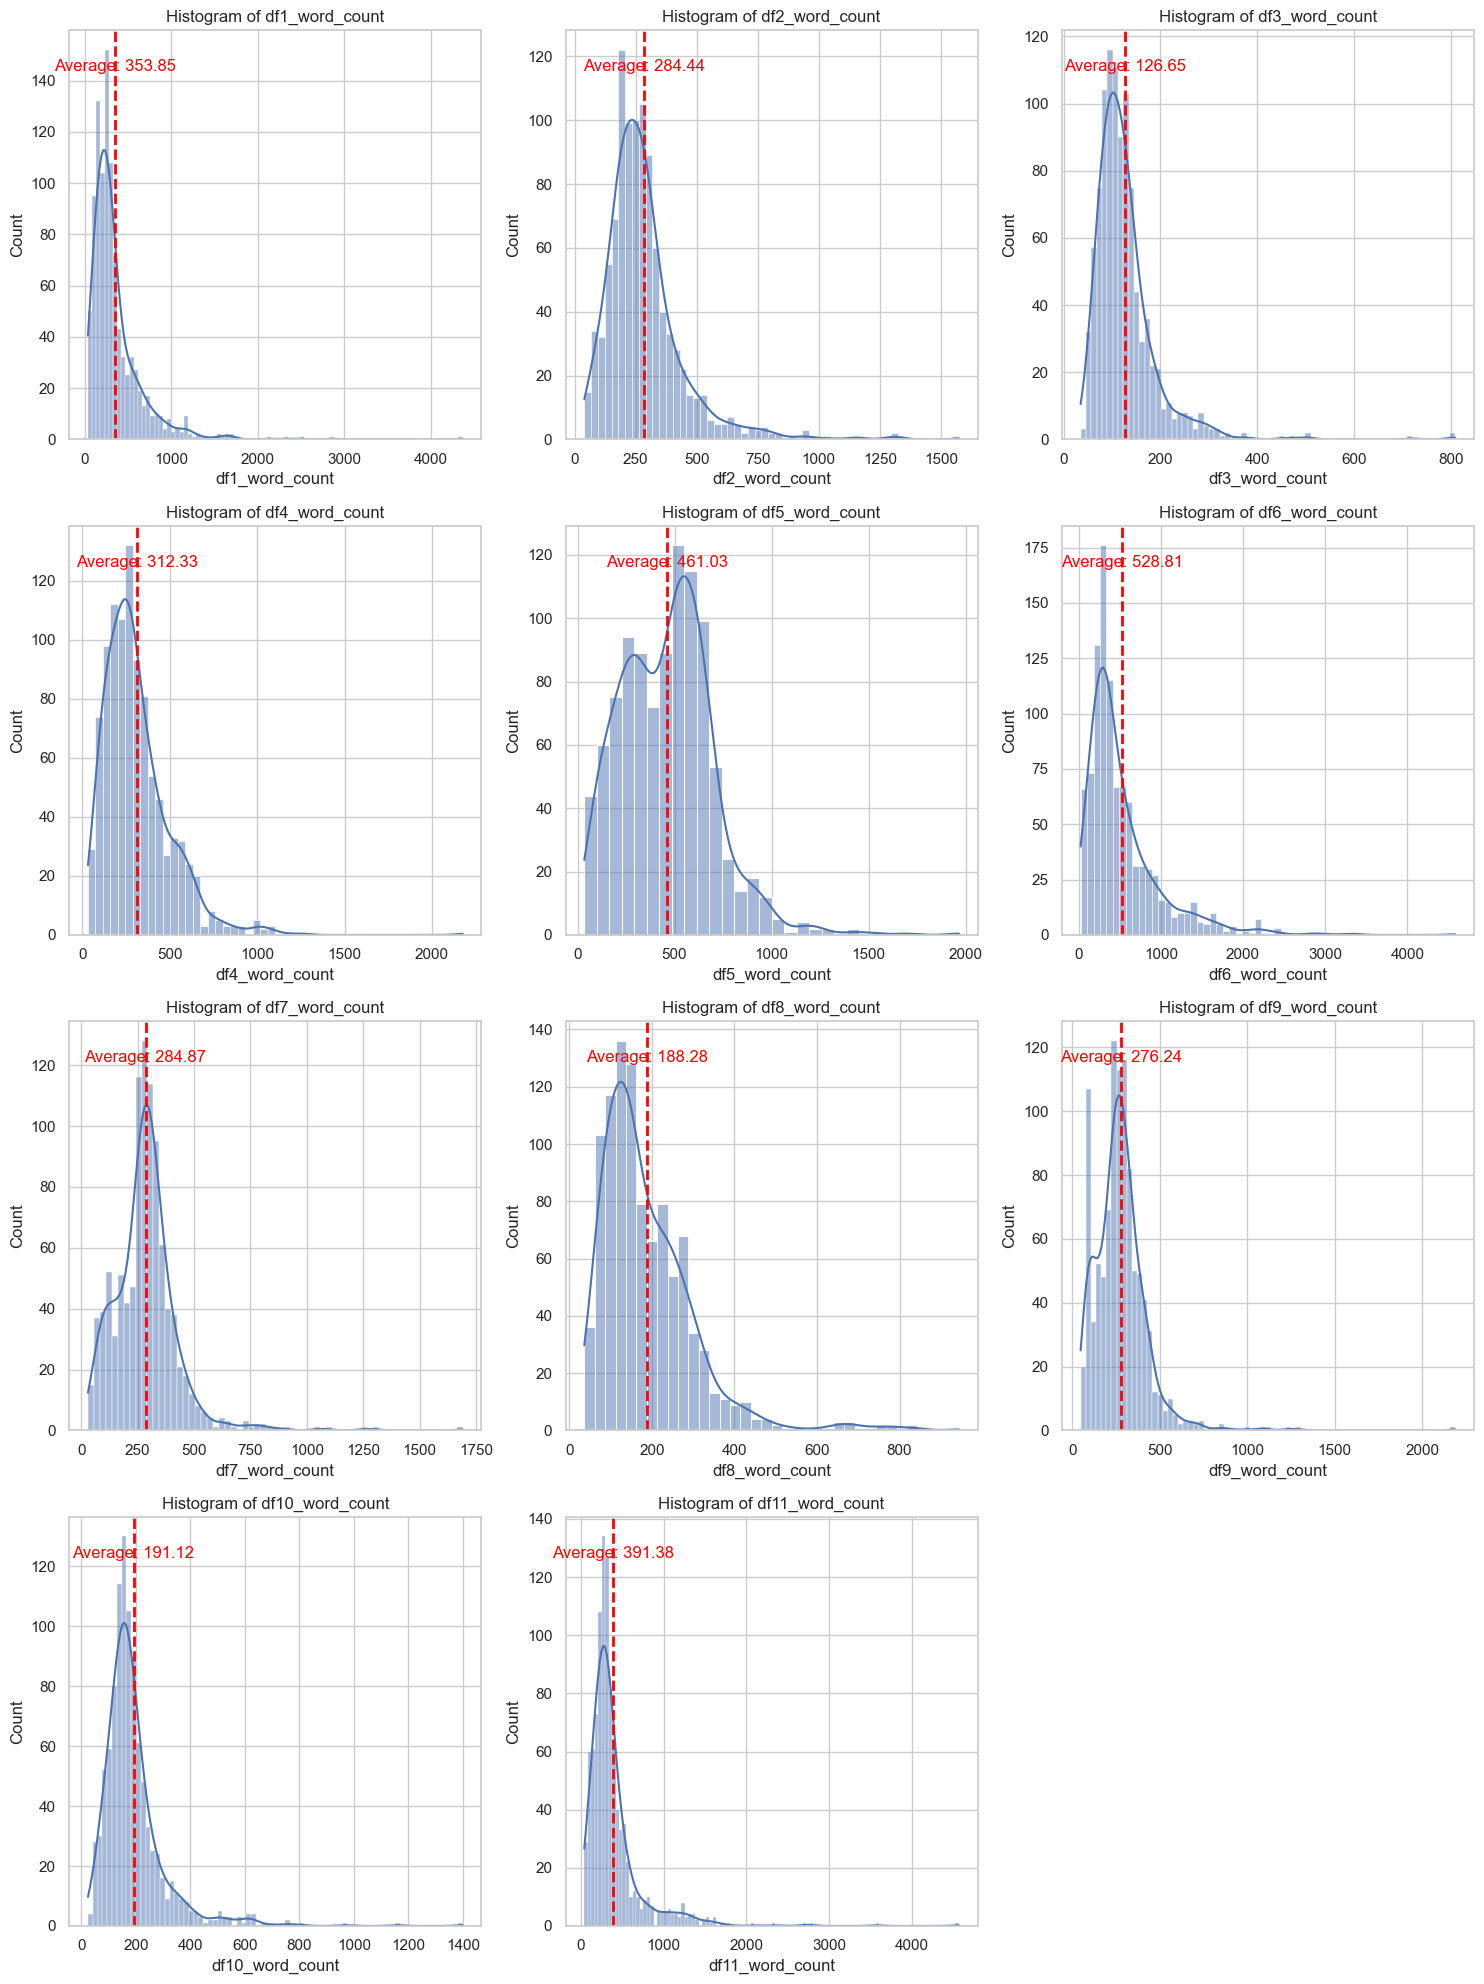

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already loaded your DataFrame
# word_count_df = pd.DataFrame({...})

# Calculate the average of each column
column_averages = word_count_df.mean()

# Define the number of columns in your DataFrame
num_columns = len(word_count_df.columns)

# Calculate the number of rows and columns for subplots
num_rows = (num_columns + 2) // 3
num_cols = min(3, num_columns)

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Flatten the axs array in case we have fewer than 3 columns
axs = axs.flatten()

# Plot histograms and add average annotations for each column
for i, column in enumerate(word_count_df.columns):
    sns.histplot(word_count_df[column], ax=axs[i], kde=True)
    axs[i].set_title(f"Histogram of {column}")
    axs[i].set_xlabel(column)

    # Calculate the average value for the current column
    avg_value = column_averages[column]
    axs[i].axvline(avg_value, color='red', linestyle='dashed', linewidth=2)
    axs[i].text(avg_value, axs[i].get_ylim()[1]*0.9, f'Average: {avg_value:.2f}', color='red', ha='center')

# Remove any empty subplots
for i in range(num_columns, num_rows * num_cols):
    axs[i].axis('off')

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plot
plt.show()
